In [1]:
import torch
import os
import pandas as pd
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import ndcg_score
from math import ceil
from utils import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
df = pd.read_csv('intern_task.csv')
df = sort_df(df)
df

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.0,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,2,10,3.0,3.0,3.0,1.0,3.0,1.000000,1.0,1.000000,...,0.0,0.0,0.142857,0.998020,22.936731,0.333333,0.022648,0.000009,31.0,10.333333
2,0,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,2,10,3.0,0.0,0.0,0.0,3.0,1.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.997559,0.000000,0.000000,0.010774,0.000001,16.0,5.333333
4,1,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235253,1,29995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
235254,1,29995,1.0,1.0,1.0,1.0,1.0,0.500000,0.5,0.500000,...,0.0,0.0,0.111111,0.471409,13.302685,0.500000,0.019608,0.000037,1.0,0.500000
235255,2,29995,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.0,0.000000,0.471409,0.000000,0.000000,0.003916,0.000017,3.0,1.500000
235256,1,29995,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.0,0.000000,0.471409,0.000000,0.000000,0.003077,0.000010,4.0,2.000000


In [3]:
df = drop_features(df)

name: feature_64 | item: 0 | dtype: int64
name: feature_65 | item: 0 | dtype: int64
name: feature_72 | item: 1 | dtype: int64
name: feature_100 | item: 0 | dtype: int64


In [4]:
df_train, df_test = train_test(df)

In [5]:
df_train = fix_class_dist(df_train)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
class CustomDataset_train(Dataset):
    def __init__(self, df, scale=False):

        self.df = df
        self.groupped_df = group_by(df)
        self.features = df.drop(['rank', 'query_id'], axis=1).to_numpy()

        self.scaler = None
        
        if scale:
            scaler = StandardScaler()
            scaler.fit(self.features)
            self.features = scaler.transform(self.features)
            self.scaler = scaler

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):

        q = self.df['query_id'][idx]
        low_idx, high_idx = self.groupped_df[q][0], self.groupped_df[q][-1]
        i, j = np.random.randint(low_idx, high_idx + 1, size=2)
        r_i = self.df['rank'][i]
        r_j = self.df['rank'][j]
        X_i = self.features[i]
        X_j = self.features[j]
        
        return X_i, X_j, r_i, r_j

In [7]:
train_dataset = CustomDataset_train(df_train, scale=True)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=1024)

In [9]:
class RankNet(torch.nn.Module):

    def __init__(self, n_feature):
        super().__init__()

        self.model = nn.Sequential(
                    nn.Linear(n_feature, 512),
                    nn.ReLU(),
                    nn.BatchNorm1d(512),
                    nn.Dropout(0.3),
                    nn.Linear(512, 256),
                    nn.ReLU(),
                    nn.BatchNorm1d(256),
                    nn.Linear(256, 64),
                    nn.ReLU(),
                    nn.BatchNorm1d(64),
                    nn.Linear(64, 1)
                    )

    def forward(self, X):
        return self.model(X)

In [10]:
def loss_fn(r1, r2, s1, s2):
    global device
    
    S_ij = torch.zeros(size=s1.shape).to(device)
    S_ij[r1 > r2] = 1.
    S_ij[r1 < r2] = -1.

    loss = (1 - S_ij) * (s1 - s2) / 2 + torch.log1p(torch.exp(-(s1 - s2)))

    return loss.mean()

In [11]:
def train(model, optimizer, loss_fn, train_loader, test_loader=None, epochs=50, scheduler=None, scale=False):
    global device

    hist = {'train_loss': [], 'test_metric': {"ndcg@5": [], "ndcg@10": []}}
    for epoch in tqdm(range(epochs)):
        model.train()
        batch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            
            X1, X2, r1, r2 = batch
            X1 = X1.to(device)
            X2 = X2.to(device)
            r1 = r1.to(device)
            r2 = r2.to(device)
            
            s1 = model(X1.float())
            s2 = model(X2.float())
            loss = loss_fn(r1, r2, s1, s2)
            loss.backward()
            optimizer.step()
            batch_loss += loss.cpu().data
        if scheduler is not None:
            scheduler.step()
        if test_loader is not None:
            model.eval()
            if scale:
                ndcg = test(model=model, test_df=test_loader, scaler=train_loader.dataset.scaler)
            else:
                ndcg = test(model=model, test_df=test_loader)
            hist['test_metric']["ndcg@5"].append(ndcg["ndcg@5"][0])
            hist['test_metric']["ndcg@10"].append(ndcg["ndcg@10"][0])
        hist['train_loss'].append(batch_loss.item())
        
        if (epoch + 1) % 10 == 0:
            PATH = os.path.join('nn_models_cheskpoints', f'model_{epoch + 1}.pt')
            torch.save(model.state_dict(), PATH)
            print(f"Train loss after epoch #{epoch + 1}: {hist['train_loss'][-1]}")
            print(f"Test metric after epoch #{epoch + 1}: {hist['test_metric']['ndcg@5'][-1]}")

    return hist

def test(model, test_df, scaler=None):

    metrics = {"ndcg@5": [],"ndcg@10": []}
    test_q = test_df['query_id'].unique()
    for q in test_q:
        ndcg_in_q_5 = []
        ndcg_in_q_10 = []
        X = test_df[test_df['query_id'] == q].drop(['query_id', 'rank'], axis=1).to_numpy()
        if scaler is not None:
            X = scaler.transform(X)
        y = test_df[test_df['query_id'] == q]['rank'].to_numpy()
        # нет никакого смылса считать метрику для query с 1 документом - это только завысит среднее значение
        if y.shape[-1] == 1:
            continue
        X = torch.tensor(X).float().to(device)
        with torch.no_grad():
            pred = model(X).cpu().numpy().T
        y = y.reshape((1, -1))
        ndcg_q_5 = ndcg_score(y, pred, k=5, ignore_ties=True)
        ndcg_q_10 = ndcg_score(y, pred, k=10, ignore_ties=True)
        ndcg_in_q_5.append(ndcg_q_5)
        ndcg_in_q_10.append(ndcg_q_10)
    metrics["ndcg@5"].append(np.mean(ndcg_in_q_5))
    metrics["ndcg@10"].append(np.mean(ndcg_in_q_10))
    return metrics


In [12]:
n_features = df.shape[1] - 2
EPOCHS = 50
LR = 5e-4
model = RankNet(n_feature=n_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = None#MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
loss_fun = loss_fn

In [13]:
result = train(model=model, optimizer=optimizer, loss_fn=loss_fun,
      train_loader=train_loader, test_loader=df_test, scale=True, epochs=EPOCHS, scheduler=scheduler)

  0%|          | 0/50 [00:00<?, ?it/s]

Train loss after epoch #10: 193.60540771484375
Test metric after epoch #10: 0.8474870656778775
Train loss after epoch #20: 180.86102294921875
Test metric after epoch #20: 0.9020243604942442
Train loss after epoch #30: 174.0074005126953
Test metric after epoch #30: 0.9510121802471221
Train loss after epoch #40: 169.7010498046875
Test metric after epoch #40: 0.8419375906143888
Train loss after epoch #50: 166.77386474609375
Test metric after epoch #50: 0.9510121802471221


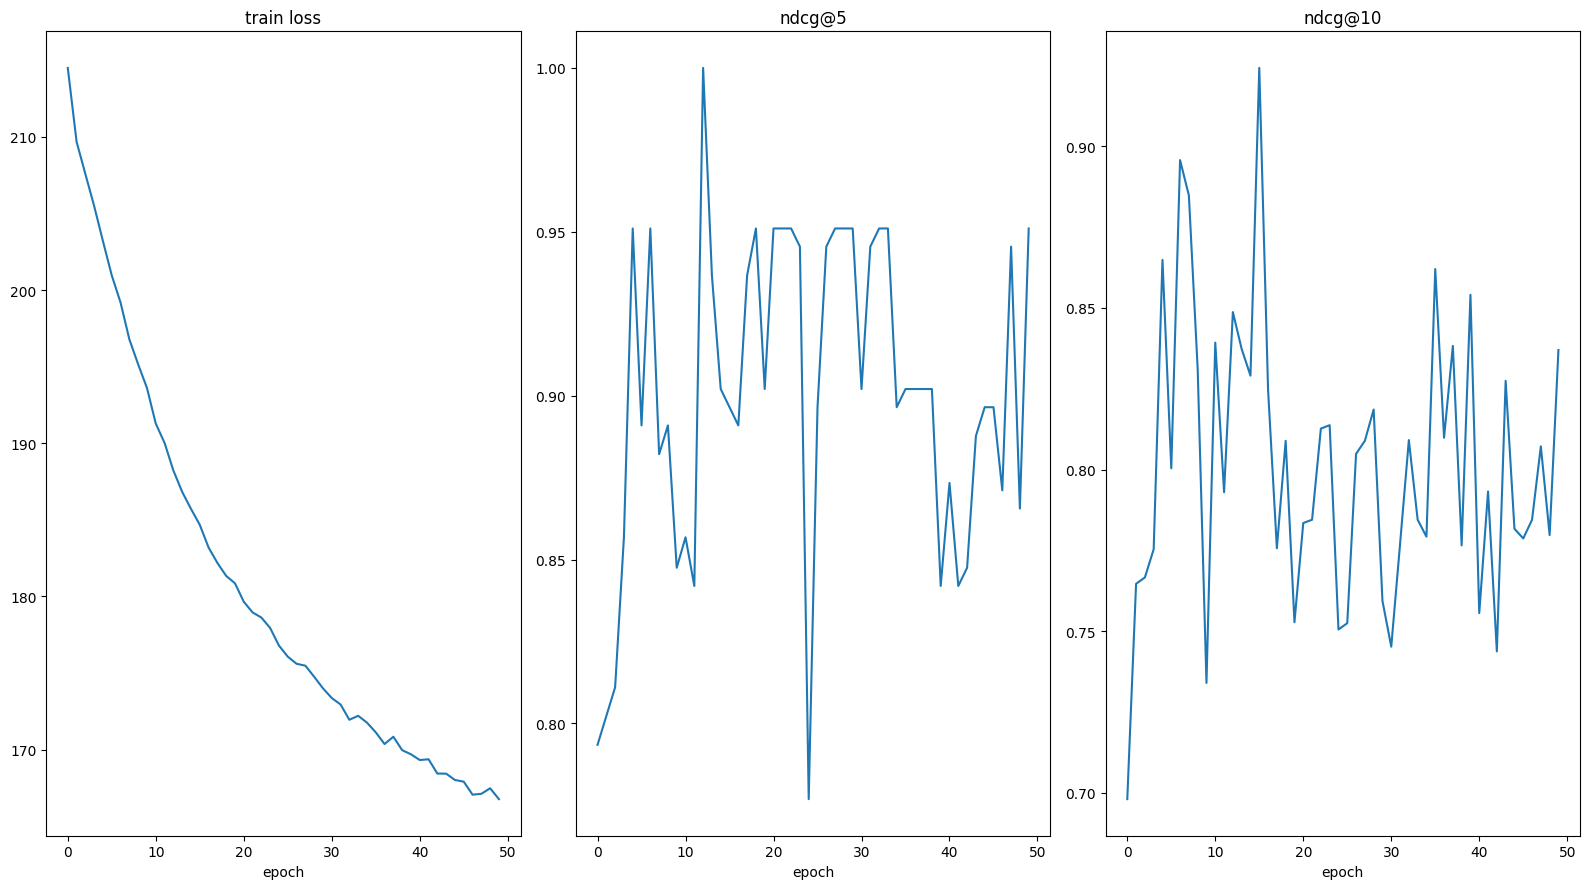

In [14]:
fig, ax = plt.subplots(1, 3, tight_layout=True, dpi=100, figsize=(16, 9))
ax[0].plot(result['train_loss'])
ax[0].set_title('train loss')
ax[0].set_xlabel('epoch')
ax[1].plot(result['test_metric']['ndcg@5'])
ax[1].set_title('ndcg@5')
ax[1].set_xlabel('epoch')
ax[2].plot(result['test_metric']['ndcg@10'])
ax[2].set_title('ndcg@10')
ax[2].set_xlabel('epoch')
None